## Imports

In [1]:
import os
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm.notebook import tqdm

## Setups

In [2]:
# Set dark style
plt.style.use("dark_background")

# BraTS2020 uploads on Kaggle
DATA_PATH = "/kaggle/input/datasets/awsaf49/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Load the mapping CSV
csv_path = "/kaggle/input/datasets/awsaf49/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv"
survival_path = "/kaggle/input/datasets/awsaf49/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv"

# Get list of train directories
train_dirs = [f.path for f in os.scandir(DATA_PATH) if f.is_dir()]
print(f"Total Patients found: {len(train_dirs)}")

Total Patients found: 369


## Utility Func: Load Patient

In [3]:
def load_patient_data(patient_path):
    """
    Loads the 4 modalities and the segmentation mask for a single patient.
    """
    # Extract patient ID from path
    patient_id = os.path.basename(patient_path)

    t1_path = os.path.join(patient_path, f"{patient_id}_t1.nii")
    t1ce_path = os.path.join(patient_path, f"{patient_id}_t1ce.nii")
    t2_path = os.path.join(patient_path, f"{patient_id}_t2.nii")
    flair_path = os.path.join(patient_path, f"{patient_id}_flair.nii")
    seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")

    t1 = nib.load(t1_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    return t1, t1ce, t2, flair, seg

## Utility Func: Show Slice

In [4]:
def show_slice(t1, t1ce, t2, flair, seg, slice_num):
    """
    Visualizes a specific slice index across all modalities.
    """
    _, ax = plt.subplots(1, 5, figsize=(20, 5))

    ax[0].imshow(t1[:, :, slice_num], cmap="gray")
    ax[0].set_title("T1")

    ax[1].imshow(t1ce[:, :, slice_num], cmap="gray")
    ax[1].set_title("T1ce")

    ax[2].imshow(t2[:, :, slice_num], cmap="gray")
    ax[2].set_title("T2")

    ax[3].imshow(flair[:, :, slice_num], cmap="gray")
    ax[3].set_title("FLAIR")

    masked_seg = np.ma.masked_where(seg[:, :, slice_num] == 0, seg[:, :, slice_num])
    ax[4].imshow(t1ce[:, :, slice_num], cmap="gray", alpha=0.6)  # Background image
    ax[4].imshow(masked_seg, cmap="prism", alpha=0.5)  # Overlay
    ax[4].set_title("Segmentation Overlay")

    for a in ax:
        a.axis("off")

    plt.show()

## Utility Func: Class Distribution

In [5]:
def get_class_distribution(train_dirs, num_samples=20):
    class_counts = {0: 0, 1: 0, 2: 0, 4: 0}

    print(f"Analyzing {num_samples} patients for class distribution...")

    for i in tqdm(range(num_samples)):
        path = train_dirs[i]
        try:
            patient_id = os.path.basename(path)
            seg_path = os.path.join(path, f"{patient_id}_seg.nii")
            seg = nib.load(seg_path).get_fdata()

            unique, counts = np.unique(seg, return_counts=True)
            for u, c in zip(unique, counts):
                if u in class_counts:
                    class_counts[u] += c
        except Exception as e:
            print(f"Error reading {path}: {e}")
            continue

    return class_counts

## Utility Func: Pixel Distribution

In [6]:

def extract_patient_stats(train_dirs, num_samples=None):
    """
    Calculates shape and mean intensity per channel for a list of patients.
    If num_samples is None, it runs on all patients.
    """
    stats_list = []

    # Use a subset if specified, otherwise use all
    dirs_to_process = train_dirs[:num_samples] if num_samples else train_dirs

    print(f"Processing {len(dirs_to_process)} patients...")

    for patient_path in tqdm(dirs_to_process):
        patient_id = os.path.basename(patient_path)

        t1, t1ce, t2, flair, seg = load_patient_data(patient_path)

        # 1. Get Shape (All channels usually have the same shape in BraTS)
        # We check T1 as representative
        vol_shape = t1.shape

        # 2. Calculate Mean per Channel
        # Note: We often care about the mean of the 'brain' area, excluding the
        # black background (0). Here we calculate the mean of non-zero pixels
        # to get a more accurate representation of the tissue intensity.

        stats = {
            "Patient_ID": patient_id,
            "Shape": str(vol_shape),
            "T1_mean": np.mean(t1[t1 > 0]),
            "T1ce_mean": np.mean(t1ce[t1ce > 0]),
            "T2_mean": np.mean(t2[t2 > 0]),
            "FLAIR_mean": np.mean(flair[flair > 0]),
        }
        stats_list.append(stats)

    return pd.DataFrame(stats_list)

## Visualize a Patient

Visualizing Patient: BraTS20_Training_005
Showing Slice: 95


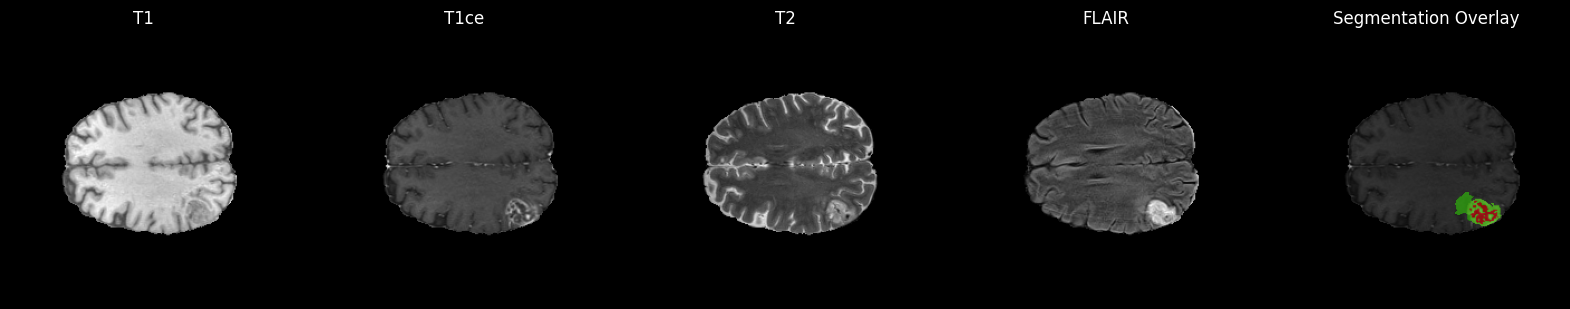

In [7]:
# Pick a random patient
random_patient_path = random.choice(train_dirs)
print(f"Visualizing Patient: {os.path.basename(random_patient_path)}")

# Load data
t1, t1ce, t2, flair, seg = load_patient_data(random_patient_path)

# Pick a slice that actually has a tumor (we scan for one)
# We sum the segmentation mask to find a slice with high activity
slice_with_max_tumor = np.argmax(np.sum(seg, axis=(0, 1)))
print(f"Showing Slice: {slice_with_max_tumor}")
show_slice(t1, t1ce, t2, flair, seg, slice_with_max_tumor)

## Class Distribution Analysis

Analyzing 50 patients for class distribution...


  0%|          | 0/50 [00:00<?, ?it/s]

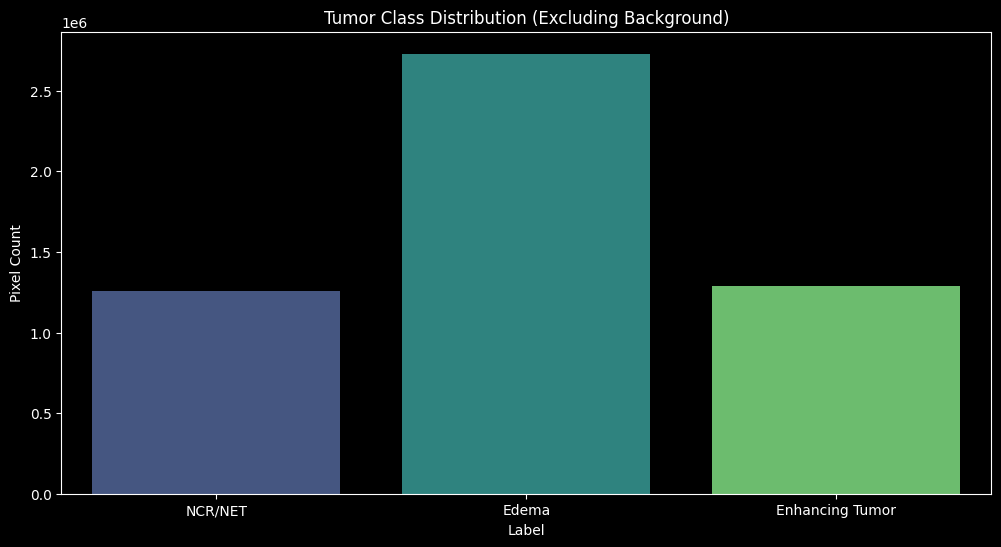

In [8]:
# Run stats on a subset
counts = get_class_distribution(train_dirs, num_samples=50)

# Convert to DataFrame for Plotting
df_counts = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])
# Map Class IDs to Names
class_map = {0: "Background", 1: "NCR/NET", 2: "Edema", 4: "Enhancing Tumor"}
df_counts["Label"] = df_counts["Class"].map(class_map)

# Exclude Background for better scale visualization of tumor classes
df_tumor = df_counts[df_counts["Class"] != 0]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_tumor, x="Label", y="Count", hue="Label", palette="viridis", legend=False
)
plt.title("Tumor Class Distribution (Excluding Background)")
plt.ylabel("Pixel Count")
plt.show()

## Dataset Health Check (Metadata)

In [9]:
df_survival = pd.read_csv(survival_path)
print("Survival Data Loaded:")
display(df_survival.head())

Survival Data Loaded:


,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


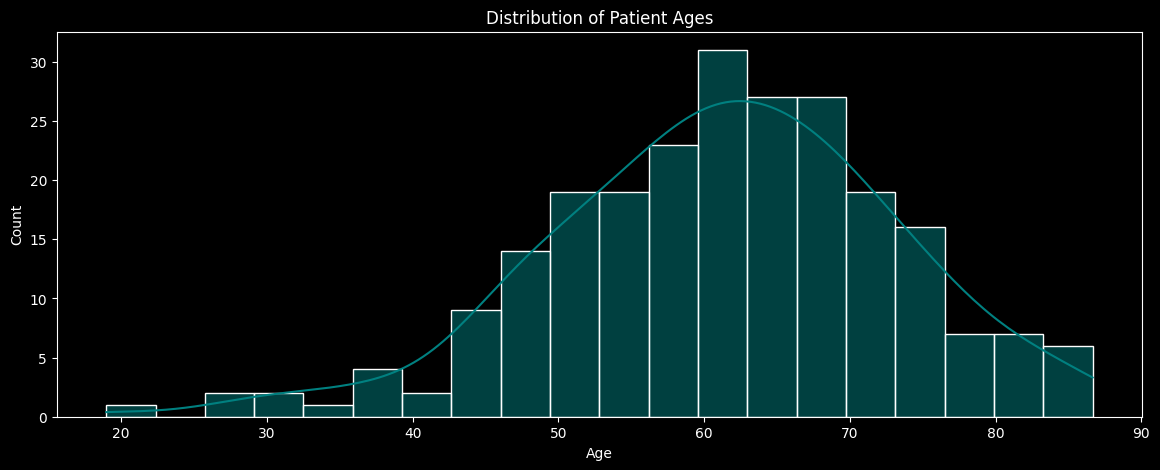

In [10]:
plt.figure(figsize=(14, 5))
sns.histplot(df_survival["Age"], kde=True, bins=20, color="teal")
plt.title("Distribution of Patient Ages")
plt.show()

## Pixel Values Distribution

In [11]:
df_stats = extract_patient_stats(train_dirs, num_samples=50)

# Print Shape and Values for the first few samples
print("\n--- Individual Patient Statistics (First 10) ---")
display(df_stats.head(10))

Processing 50 patients...


  0%|          | 0/50 [00:00<?, ?it/s]


--- Individual Patient Statistics (First 10) ---


,Patient_ID,Shape,T1_mean,T1ce_mean,T2_mean,FLAIR_mean
0,BraTS20_Training_083,"(240, 240, 155)",357.125718,386.309549,140.378911,180.612560
1,BraTS20_Training_337,"(240, 240, 155)",2196.836285,2713.859941,1756.361489,785.021636
2,BraTS20_Training_161,"(240, 240, 155)",1131.128679,3133.462200,1008.586064,528.897128
3,BraTS20_Training_198,"(240, 240, 155)",280.038752,335.651322,323.952637,130.268808
4,BraTS20_Training_284,"(240, 240, 155)",773.561773,699.176492,823.101771,949.290540
5,BraTS20_Training_169,"(240, 240, 155)",2575.363765,3343.962552,1254.460778,508.932276
6,BraTS20_Training_157,"(240, 240, 155)",1128.165987,798.372729,2746.378399,860.407607
7,BraTS20_Training_073,"(240, 240, 155)",340.202720,391.440443,145.803614,154.074544
8,BraTS20_Training_253,"(240, 240, 155)",337.888502,369.770255,506.774649,347.246025
9,BraTS20_Training_026,"(240, 240, 155)",802.214343,418.585400,165.733163,224.296499


In [12]:
# Check for inconsistent shapes
unique_shapes = df_stats["Shape"].unique()
print(f"\nUnique Shapes found in dataset: {unique_shapes}")
if len(unique_shapes) > 1:
    print("WARNING: Dataset contains variable volume dimensions!")
else:
    print("PASS: All volumes have consistent dimensions.")


Unique Shapes found in dataset: ['(240, 240, 155)']
PASS: All volumes have consistent dimensions.


In [13]:
# Global Mean Statistics (Average across the dataset)
print("\n--- Global Mean Values per Channel ---")
display(df_stats[["T1_mean", "T1ce_mean", "T2_mean", "FLAIR_mean"]].describe())


--- Global Mean Values per Channel ---


,T1_mean,T1ce_mean,T2_mean,FLAIR_mean
count,50.000000,50.000000,50.000000,50.000000
mean,677.462484,881.636290,790.645258,369.825108
std,630.724530,951.129605,676.287838,254.598128
min,209.505050,48.709124,125.254319,126.664842
25%,310.464044,355.059746,370.235561,163.625887
50%,360.087045,401.165952,520.395271,280.673853
75%,705.408205,873.456080,962.214991,508.176119
max,2575.363765,3343.962552,3214.342321,949.290540


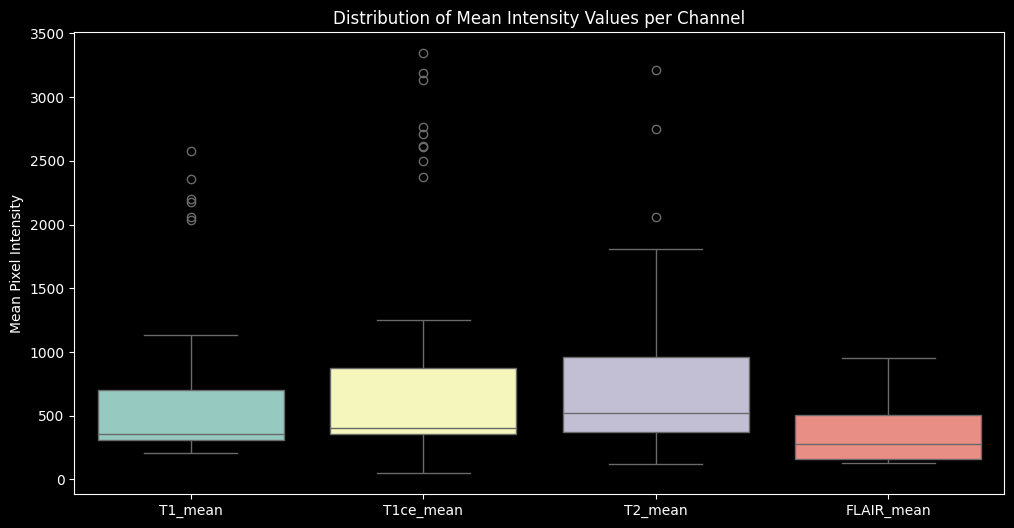

In [14]:
# Visualize the spread of means
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_stats[["T1_mean", "T1ce_mean", "T2_mean", "FLAIR_mean"]])
plt.title("Distribution of Mean Intensity Values per Channel")
plt.ylabel("Mean Pixel Intensity")
plt.show()